# Report on Beach Venues

## Introduction
During summer vacation is common to go to beaches and their seaside venues and enjoy the warm weather. Many famous beaches nowadays have been developing during many years and are in a continuos process of renewing and improving its venues.<br>
Our report aims to evaluate the top beaches of the world and the kind of venues they have in common, helping guide future beach developers/city planners to invest in best venues to increase turism.

## Data Description
Data will be collected from different sources:
* To identify the best beaches in the world, data will be collected from the website TripAdvisor. Anually they make a traveller choice award that rank the best turist attractions around the world. For this report will be used the Travellers' Choice 2021 top beaches in the world and in each region [1].
* To identify the best venues in each beach will be used Foursquare API [2].
* Beaches are going to be grouped by venues similarities, creating different kinds of beaches categories that can be choose to atract tourists.

## Methodology

In [1]:
import pandas as pd 
import numpy as np
import requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#import geopy to find beaches coordinates
from geopy.geocoders import Nominatim
from geopy.geocoders import GoogleV3


# map rendering library
import folium 

The beaches database was a previously created CSV with the data from TripAdvisor Travellers' Choice 2021 top beaches in the world and in each region [1].

In [2]:
df = pd.read_csv(r"C:\Users\Lucas\Documents\Cursos\IBM data science\10. Applied Data Science Capstone\Dados praias.csv", delimiter=';')

df.head()

,Beach Name,Location,List
0,Anse Coco Beach,"La Digue Island, Seychelles",Africa
1,Anse Lazio,"Praslin Island, Seychelles",Africa
2,Belle Mare Beach,"Belle Mare, Mauritius",Africa
3,Clifton Beaches,"Cape Town Central, South Africa",Africa
4,Diani Beach,"Diani Beach, Kenya",Africa


In [3]:
df["Latitude"] = ""
df["Longitude"] = ""
df.head()

,Beach Name,Location,List,Latitude,Longitude
0,Anse Coco Beach,"La Digue Island, Seychelles",Africa,,
1,Anse Lazio,"Praslin Island, Seychelles",Africa,,
2,Belle Mare Beach,"Belle Mare, Mauritius",Africa,,
3,Clifton Beaches,"Cape Town Central, South Africa",Africa,,
4,Diani Beach,"Diani Beach, Kenya",Africa,,


As the database didn't have coordinates it was used GoogleMapsAPI to geocode the addresses (Beach Name plus Location). It was checked if were any empty/NaN value on the coordinates, but the geocoding could find coordinated to all beaches.

In [4]:
#looping to fill coordinates for each beach
for index, row in df.iterrows():
    address = row["Beach Name"] + ", " + row["Location"]
    geolocator = GoogleV3(api_key='')
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    row["Latitude"] = latitude
    row["Longitude"] = longitude

df.head()

,Beach Name,Location,List,Latitude,Longitude
0,Anse Coco Beach,"La Digue Island, Seychelles",Africa,-4.367327,55.853759
1,Anse Lazio,"Praslin Island, Seychelles",Africa,-4.295681,55.70437
2,Belle Mare Beach,"Belle Mare, Mauritius",Africa,-20.182676,57.774169
3,Clifton Beaches,"Cape Town Central, South Africa",Africa,-33.940576,18.375125
4,Diani Beach,"Diani Beach, Kenya",Africa,-4.276957,39.594769


In [5]:
#Check if all beaches have coordinates
df.isnull().values.any()

False

Using folium library was created a world map with the beaches locations. <br>As expected most beaches on the list are near or around the tropical area. There are two big cluster of beaches (Caribbean and Mediterranean) that are worldly renowned. And it is also possible to see that beaches in the Southern Hemisphere (South America, Africa and Oceania) are under represented on this dataset. 

In [30]:
map_beaches = folium.Map(location=[0.00, 0.00])

marker_cluster = MarkerCluster().add_to(map_beaches)
# add markers to map
for lat, lng, beach in zip(df['Latitude'], df['Longitude'], df['Beach Name']):
    label = '{}'.format(beach)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_beaches)  

map_beaches.fit_bounds([(-90,-180), (90,180)]) 
map_beaches

In [7]:
import json # library to handle JSON files


Using FourSquare API it was explored the venues in each beach in a 1000m radius and a limit of 100 venuesfrom the central point of each beach. This distance was selected because 1km is a confortable distance to walk for most people and because almost half of this search area would be inside water in any coastal point.

In [8]:
# set foursquare api
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value


In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Beach Name', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
beach_venues = getNearbyVenues(names=df['Beach Name'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'],
                                   radius=1000
                                  )

In [32]:
beach_venues.head()

,Beach Name,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Anse Coco Beach,-4.367327,55.853759,Anse Cocos,-4.365462,55.850198,Beach
1,Anse Coco Beach,-4.367327,55.853759,anse caïman,-4.362091,55.854785,Beach
2,Anse Coco Beach,-4.367327,55.853759,Petite Anse La Digue,-4.370652,55.847187,Beach
3,Anse Coco Beach,-4.367327,55.853759,Petit Anse,-4.370687,55.847018,Beach
4,Anse Coco Beach,-4.367327,55.853759,Petite Anse Beach Bar,-4.371222,55.845750,Juice Bar


In [33]:
beach_venues.shape

(4286, 7)

Analysing the venue data extracted from FourSquare API it was possible to see that many venues are the beaches themselves and some of the beaches are so isolated that did not return any venue at all (141 beaches in the dataset x 133 beaches with venues found). So it was excluded all venues categories that are beaches and all beaches from the original data set that do not have venues were grouped on a venue category named Only Beaches.<br>
Besides that it was possible to analyse the venues categories and to exclude some categories that do not fit our problem. For exemple: it was excluded any accomodation (as hotel or resort) and hotel venues (as hotel bar or hotel pool) because these venues are generally exclusive and tourists usually do not change hotels in a single vacation.

In [35]:
#grouped by beaches to see difference between foursquare extracted data and original data sizes
beach_venues.groupby('Beach Name').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Beach Name,,,,,,
Agonda Beach,17,17,17,17,17,17
An Bang Beach,18,18,18,18,18,18
Anakena Beach,5,5,5,5,5,5
Anse Coco Beach,5,5,5,5,5,5
Anse Lazio,4,4,4,4,4,4
...,...,...,...,...,...,...
Waikiki Beach,100,100,100,100,100,100
Wailea Beach,78,78,78,78,78,78
White Beach,64,64,64,64,64,64


In [36]:
print('There are {} uniques categories.'.format(len(beach_venues['Venue Category'].unique())))

There are 316 uniques categories.


In [44]:
#create array to analyse venues types
beach_venues["Venue Category"].unique()

array(['Beach', 'Juice Bar', 'Restaurant', 'Café', 'Seafood Restaurant',
       'Gift Shop', 'Hotel', 'Resort', 'Beach Bar', 'Lounge',
       'Scenic Lookout', 'Bar', 'Park', 'Golf Course', 'Hotel Bar',
       'Comfort Food Restaurant', 'Coffee Shop', 'Surf Spot',
       'African Restaurant', 'Pizza Place', 'Italian Restaurant',
       'Athletics & Sports', 'French Restaurant', 'Dive Shop',
       'Supermarket', 'Buffet', 'Theater', 'Mediterranean Restaurant',
       'Asian Restaurant', 'Spa', 'Nightclub', 'Portuguese Restaurant',
       'Theme Restaurant', 'Breakfast Spot', 'Hotel Pool',
       'State / Provincial Park', 'Steakhouse', 'Frozen Yogurt Shop',
       'Burger Joint', 'Sushi Restaurant', 'Salad Place',
       'Indie Movie Theater', 'American Restaurant', 'Yoga Studio', 'Gym',
       'New American Restaurant', 'Molecular Gastronomy Restaurant',
       'Cycle Studio', 'Pilates Studio', 'Mexican Restaurant',
       'Farmers Market', 'Shopping Plaza', 'Pub', 'Lingerie Store',
 

In [350]:
#create list with venues categories that do not fit our problem
categories_excluded = ['Beach', 'Hotel', 'Resort', 'Hotel Bar', 'Hotel Pool',
                       'Bed & Breakfast', 'Hostel', 'Motel', 'RV Park', 'Neighborhood', 'Scenic Lookout',
                       'Other Great Outdoors', 'Vacation Rental', 'Campground', 'Bay']

In [351]:
#create new dataframe without the venues categories that do not fit our problem
beach_venues_cleaned = beach_venues[~beach_venues['Venue Category'].isin(categories_excluded)]
beach_venues_cleaned.head()

,Beach Name,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
4,Anse Coco Beach,-4.367327,55.853759,Petite Anse Beach Bar,-4.371222,55.845750,Juice Bar
5,Anse Lazio,-4.295681,55.704370,Le Chevalier,-4.293246,55.702361,Restaurant
6,Anse Lazio,-4.295681,55.704370,Honesty bar,-4.294196,55.701379,Café
7,Anse Lazio,-4.295681,55.704370,Bonbon Plume,-4.292972,55.702297,Seafood Restaurant
8,Anse Lazio,-4.295681,55.704370,Souvenir LangarPirog,-4.298542,55.712507,Gift Shop


In [352]:
#reset dataframe index
beach_venues_cleaned = beach_venues_cleaned.reset_index()
beach_venues_cleaned.drop(labels='index', axis=1, inplace=True)
beach_venues_cleaned.head()

,Beach Name,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Anse Coco Beach,-4.367327,55.853759,Petite Anse Beach Bar,-4.371222,55.845750,Juice Bar
1,Anse Lazio,-4.295681,55.704370,Le Chevalier,-4.293246,55.702361,Restaurant
2,Anse Lazio,-4.295681,55.704370,Honesty bar,-4.294196,55.701379,Café
3,Anse Lazio,-4.295681,55.704370,Bonbon Plume,-4.292972,55.702297,Seafood Restaurant
4,Anse Lazio,-4.295681,55.704370,Souvenir LangarPirog,-4.298542,55.712507,Gift Shop


In [353]:
beach_venues_cleaned.shape

(3102, 7)

In [354]:
#grouped by beaches to see difference between data cleaned and original data sizes
beach_venues_cleaned.groupby('Beach Name').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Beach Name,,,,,,
Agonda Beach,12,12,12,12,12,12
An Bang Beach,16,16,16,16,16,16
Anakena Beach,2,2,2,2,2,2
Anse Coco Beach,1,1,1,1,1,1
Anse Lazio,4,4,4,4,4,4
Arashi Beach,4,4,4,4,4,4
Baia do Sancho,2,2,2,2,2,2
Baia dos Golfinhos,60,60,60,60,60,60
Balandra Beach,21,21,21,21,21,21


In [355]:
# look unique categories to see if the 10 categories choosed were deleted
print('There are {} uniques categories.'.format(len(beach_venues_cleaned['Venue Category'].unique())))

There are 301 uniques categories.


In [356]:
test = beach_venues_cleaned.groupby('Beach Name').count()
test.shape

(119, 6)

After data cleaning it was found that 119 beaches of 141 have some kind of commercial venue. These venues are divided in 301 uniques categories, showing a great diversity of venues.<br>
To help classify and clusterize the beaches was selected the top 10 venues from each beach.

In [357]:
# one hot encoding
beach_onehot = pd.get_dummies(beach_venues_cleaned[['Venue Category']], prefix="", prefix_sep="")

# add beach column back to dataframe
beach_onehot['Beach Name'] = beach_venues_cleaned['Beach Name'] 

# move beach column to the first column
fixed_columns = [beach_onehot.columns[-1]] + list(beach_onehot.columns[:-1])
beach_onehot = beach_onehot[fixed_columns]

beach_onehot.head()

,Beach Name,ATM,Acai House,Accessories Store,African Restaurant,Airport,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,...,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yucatecan Restaurant,Zoo
0,Anse Coco Beach,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Anse Lazio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Anse Lazio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Anse Lazio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Anse Lazio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [358]:
#group rows by beach name
beach_grouped = beach_onehot.groupby('Beach Name').mean().reset_index()
beach_grouped.head()

,Beach Name,ATM,Acai House,Accessories Store,African Restaurant,Airport,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,...,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yucatecan Restaurant,Zoo
0,Agonda Beach,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0
1,An Bang Beach,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,Anakena Beach,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,Anse Coco Beach,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,Anse Lazio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [359]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    row_categories_sorted = row_categories_sorted[row_categories_sorted > 0]
    if row_categories_sorted.shape[0] < num_top_venues:
         return row_categories_sorted.index.values[0:row_categories_sorted.shape[0]]
    else:
        return row_categories_sorted.index.values[0:num_top_venues]

In [360]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Beach Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
beach_venues_sorted = pd.DataFrame(columns=columns)
beach_venues_sorted['Beach Name'] = beach_grouped['Beach Name']

for ind in np.arange(beach_grouped.shape[0]):
    venues_each_beach = return_most_common_venues(beach_grouped.iloc[ind, :], num_top_venues)
    beach_venues_sorted.iloc[ind, 1:(venues_each_beach.shape[0] + 1)] = venues_each_beach
beach_venues_sorted.head()

,Beach Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agonda Beach,Indian Restaurant,Café,Italian Restaurant,Bistro,Snack Place,Seafood Restaurant,Vegetarian / Vegan Restaurant,Gastropub,Restaurant,Yoga Studio
1,An Bang Beach,Beach Bar,Seafood Restaurant,Restaurant,Vietnamese Restaurant,Pub,Coffee Shop,Bakery,Italian Restaurant,NaN,NaN
2,Anakena Beach,Restaurant,Historic Site,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Anse Coco Beach,Juice Bar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Anse Lazio,Restaurant,Café,Gift Shop,Seafood Restaurant,NaN,NaN,NaN,NaN,NaN,NaN


In [361]:
beach_grouped_clustering = beach_grouped.drop('Beach Name', 1)

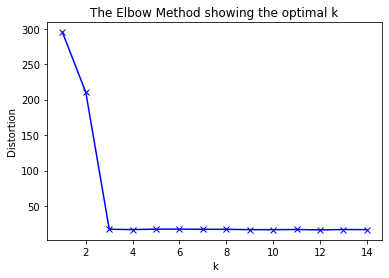

In [362]:
#choosing best k value
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(beach_grouped_clustering)
    distortions.append(sum(np.min(cdist(beach_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / beach_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [363]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(beach_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 1, 0, 1, 1, 1, 1, 1])

In [364]:
# add clustering labels
beach_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [365]:
beach_venues_sorted.groupby('Cluster Labels').count()

,Beach Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,
0,15,15,14,12,10,5,2,0,0,0,0
1,103,103,98,92,84,81,77,74,73,72,65
2,1,1,0,0,0,0,0,0,0,0,0


In [367]:
beach_venues_sorted[beach_venues_sorted["Cluster Labels"] == 2]

,Cluster Labels,Beach Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
38,2,Half Moon Bay,Clothing Store,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [368]:
# get original beach data
beach_merged = df

# merge beach_grouped with beach_data to add latitude/longitude for each neighborhood
beach_merged = beach_merged.join(beach_venues_sorted.set_index('Beach Name'), on='Beach Name')

beach_merged.head() # check the last columns!

,Beach Name,Location,List,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anse Coco Beach,"La Digue Island, Seychelles",Africa,-4.367327,55.853759,1.0,Juice Bar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Anse Lazio,"Praslin Island, Seychelles",Africa,-4.295681,55.70437,0.0,Restaurant,Café,Gift Shop,Seafood Restaurant,NaN,NaN,NaN,NaN,NaN,NaN
2,Belle Mare Beach,"Belle Mare, Mauritius",Africa,-20.182676,57.774169,1.0,Beach Bar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Clifton Beaches,"Cape Town Central, South Africa",Africa,-33.940576,18.375125,0.0,Lounge,Restaurant,Bar,Park,NaN,NaN,NaN,NaN,NaN,NaN
4,Diani Beach,"Diani Beach, Kenya",Africa,-4.276957,39.594769,0.0,Restaurant,Golf Course,Comfort Food Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [369]:
# fill beaches without venues with a cluster for them own
beach_merged['Cluster Labels'] = beach_merged['Cluster Labels'].fillna(3)
beach_merged['1st Most Common Venue'] = beach_merged['1st Most Common Venue'].fillna("Only Beach")

In [370]:
#Create a graph to help name each cluster
count_venue = beach_merged
count_venue = count_venue.drop(['Beach Name','Location', 'List', 'Latitude', 'Longitude'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

#we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue,American Restaurant,Bar,Beach Bar,Brazilian Restaurant,Café,Caribbean Restaurant,Cave,Clothing Store,Coffee Shop,Convenience Store,...,Seafood Restaurant,Snack Place,Spa,Sri Lankan Restaurant,Surf Spot,Tapas Restaurant,Thai Restaurant,Tourist Information Center,Trail,Trattoria/Osteria
0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
1,1,5,4,2,4,9,1,3,2,2,...,14,0,1,1,2,1,4,1,1,1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'Clusters')

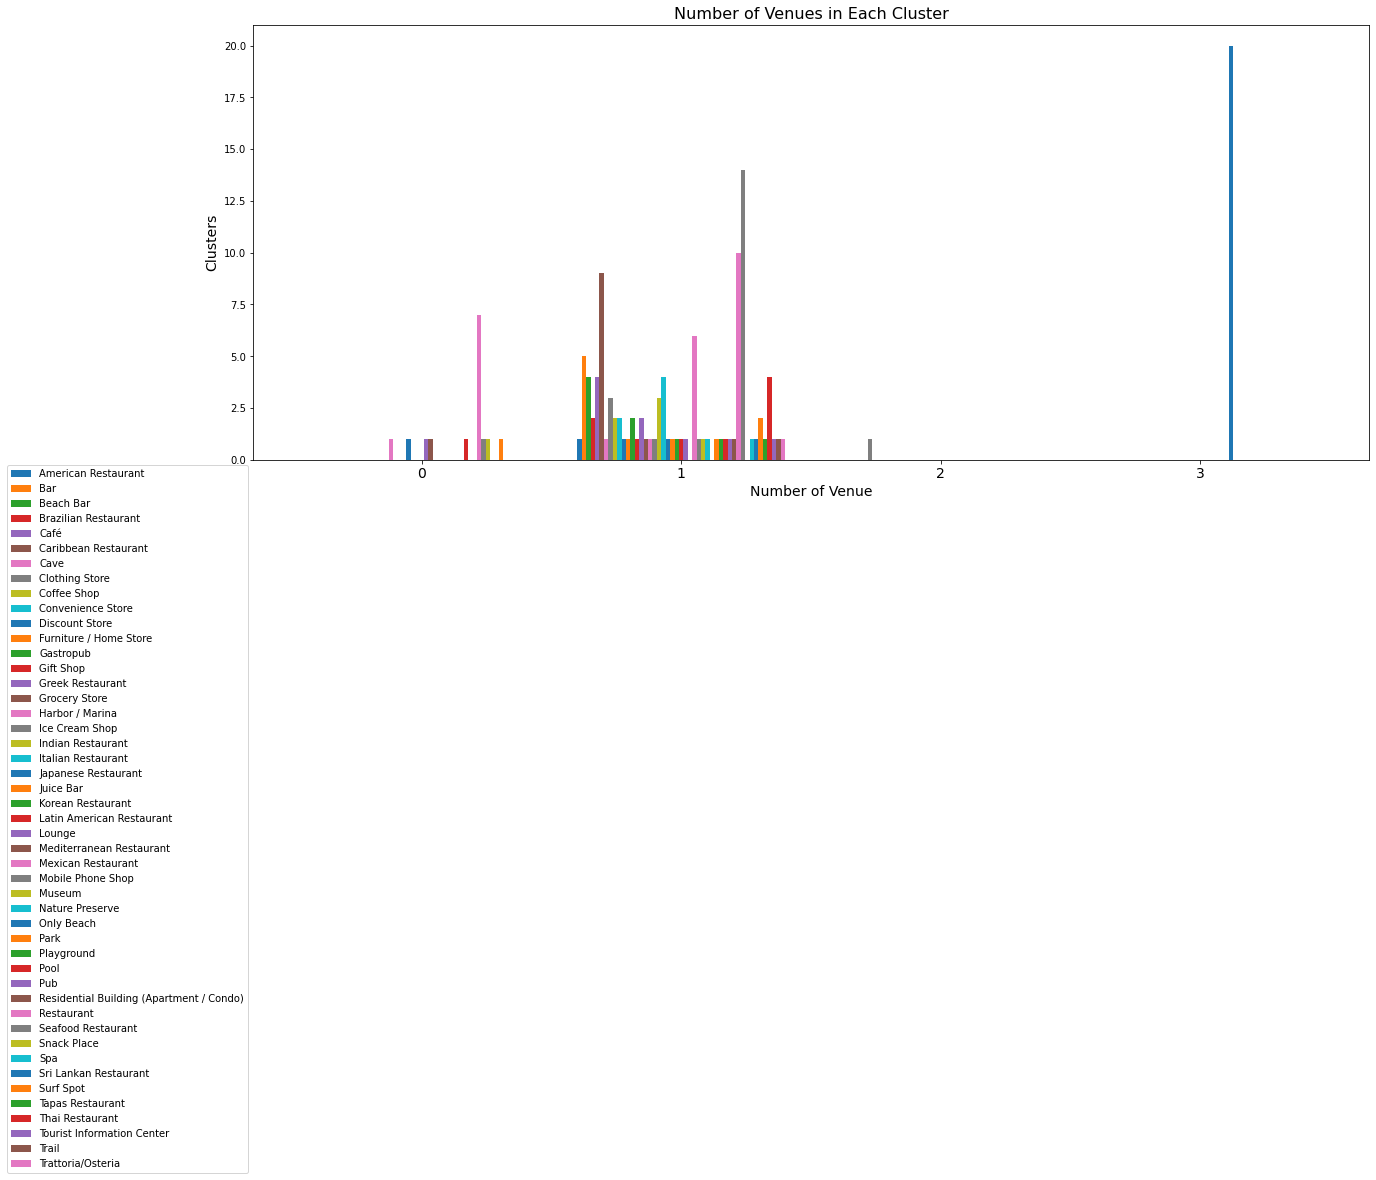

In [394]:
#creating a bar chart of "Number of Venues in Each Cluster"
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 10, bbox_to_anchor=(0, 0))
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Number of Venue', fontsize=14)
plt.ylabel('Clusters', fontsize=14)



Analyzing the clusters data it is possible to verify 3 kinds of beaches and 1 outlier:<br>
* Cluster 0 - <b>Smaller beaches</b>: there are 15 beaches in this classification. They have few venues but are more focused on food venus (restaurants).
* Cluster 1 - <b>Bigger beaches</b>: there are 103 beaches in this classification. They have a lot of venues, as Cluster 0 they also are focused on food venues but with more especialized restaurants (ethnics).
* Cluster 2 - <b>Outlier</b>: there are only one beach in this classification. The only venue found on these beach is a Clothing Store, making it being clustered alone.
* Cluster 3 - <b>Nature beaches</b>: there are 22 beaches in this classification. These beaches don't have venues nearby, being usualy preserved places.

In [400]:
# create map
map_clusters = folium.Map(location=[0, 0], zoom_start=1.5)

# set color scheme for the clusters
x = np.arange(kclusters+1)
ys = [i + x + (i*x)**2 for i in range(kclusters+1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(beach_merged['Latitude'], beach_merged['Longitude'], beach_merged['Beach Name'], beach_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters


## Results

## Discussion

## Conclusion

## References
[1] Tripadvisor - Travellers' Choice 2021:
* [World](https://www.tripadvisor.com.br/TravelersChoice-Beaches-cTop-g1)
* [Caribbean](https://www.tripadvisor.com.br/TravelersChoice-Beaches-cTop-g147237)
* [Mexico](https://www.tripadvisor.com.br/TravelersChoice-Beaches-cTop-g150768)
* [United States](https://www.tripadvisor.com.br/TravelersChoice-Beaches-cTop-g191)
* [South America](https://www.tripadvisor.com.br/TravelersChoice-Beaches-cTop-g13)
* [Europe](https://www.tripadvisor.com.br/TravelersChoice-Beaches-cTop-g4)
* [South Pacific](https://www.tripadvisor.com.br/TravelersChoice-Beaches-cTop-g8)
* [Africa](https://www.tripadvisor.com.br/TravelersChoice-Beaches-cTop-g6)
* [Asia](https://www.tripadvisor.com.br/TravelersChoice-Beaches-cTop-g2)

[2] [FourSquare API](https://developer.foursquare.com/)